In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# AlexNet

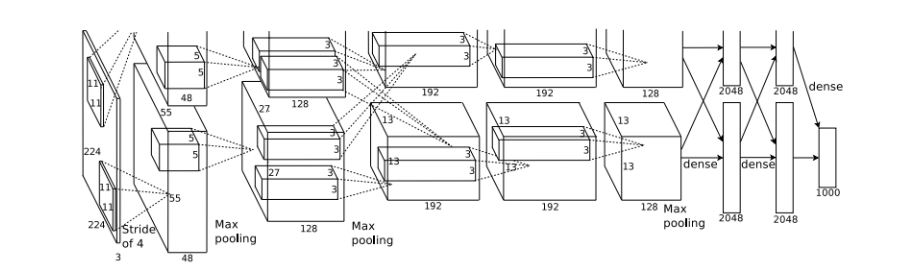

In [21]:
batch_size = 512
lr = 0.0001

class AlexNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2), # output size : 16x16
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2), # output size : 8x8
            
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2) # output size : 3x3
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 3 * 3, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, out_features=num_classes),
        )
        self.init_bias()
        
        
    def init_bias(self):
        for layer in self.net:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)
                
        nn.init.constant_(self.net[4].bias, 1)
        nn.init.constant_(self.net[10].bias, 1)
        nn.init.constant_(self.net[12].bias, 1)
        
        
    def forward(self, x):
        
        out = self.net(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        
        return out

# Data

In [22]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar10_train = datasets.CIFAR10(root="./CIFAR10/", train=True, transform=transform, target_transform=None, download=False)
cifar10_test = datasets.CIFAR10(root="./CIFAR10/", train=False, transform=transform, target_transform=None, download=False)

train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
model = AlexNet().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=lr)

for i in model.named_children():
    print(i)

cuda
('net', Sequential(
  (0): Conv2d(3, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): ReLU()
  (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
  (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
))
('classifier', Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=2304, out_features=4096, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  

# Train

In [24]:
num_epochs = 50
loss_arr = []
for i in range(num_epochs):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

    if i % 10 ==0:
        print(loss)
        loss_arr.append(loss.cpu().detach().numpy())

tensor(2.0689, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3086, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7822, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6351, device='cuda:0', grad_fn=<NllLossBackward0>)


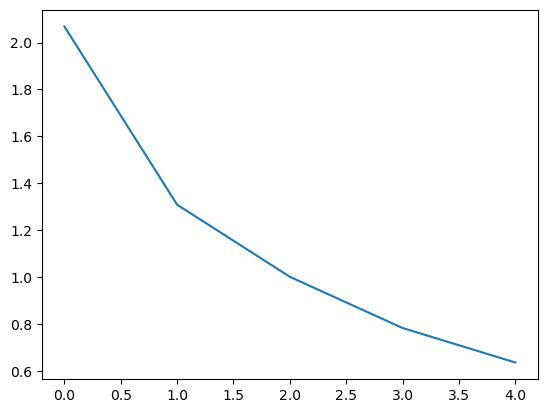

In [27]:
import matplotlib.pyplot as plt

plt.plot(loss_arr)
plt.show()

In [26]:
correct = 0 # 맞은 개수
total = 0   # 전체 개수

model.eval()
with torch.no_grad():
    for image,label in test_loader:
        
        x = image.to(device)
        y = label.to(device)

        output = model.forward(x)
        # torch.max를 이용해 최대 값 및 최대값 인덱스를 뽑아냄 (인덱스만 사용)
        _,output_index = torch.max(output,1)
        
        # 전체 개수는 라벨의 개수로 더해줌 (batch_size, drop_last의 영향으로 데이터가 잘릴 수도 있기 때문에)
        total += label.size(0)
        
        # 모델의 결과의 최대값 인덱스와 라벨이 일치하는 개수를 더해줌
        correct += (output_index == y).sum().float()
    
    print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 72.68999481201172%
